<a href="https://colab.research.google.com/github/beyzaturku/Weather_Detection_Using_CNN/blob/main/EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab ve Drive Bağlantısı


In [1]:
from google.colab import drive
import os
import glob
drive.mount('/content/drive') #google drive ı bağlamak için

Mounted at /content/drive


# Veri Ön İşleme


*   Görüntülerin yeniden boyutlandırılması
*   Verilerin eğitim ve test olarak ayrılması
*   Verilerin normalleştirilmesi



In [41]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

print('Modules loaded successfully')

Modules loaded successfully


In [42]:
# Veri seti yolu
image_folder = "/content/drive/MyDrive/Weather_Detection/Multi_Class_Weather_Dataset"
filepaths = []
labels = []

folds = os.listdir(image_folder)
for fold in folds:
  foldpath = os.path.join(image_folder, fold)

  pics = os.listdir(foldpath)
  for pic in pics:
    pic_path = os.path.join(foldpath, pic)

    filepaths.append(pic_path)
    labels.append(fold)

Fseries = pd.Series(filepaths, name = 'Pic Path')
Lseries = pd.Series(labels, name = 'Labels')

df = pd.concat([Fseries, Lseries], axis = 1)

In [45]:
# Data Frame test, train, valid olarak üçe bölmek için:
train_df, dummy_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['Labels'])
test_df,  valid_df= train_test_split(dummy_df, test_size=0.5, random_state=42, stratify=dummy_df['Labels'])

In [46]:
batch_size = 16
img_size = (224, 224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Pic Path', y_col='Labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Pic Path', y_col='Labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Pic Path', y_col='Labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 1012 validated image filenames belonging to 4 classes.
Found 57 validated image filenames belonging to 4 classes.
Found 56 validated image filenames belonging to 4 classes.


# Model Mimarisi Kurma - EfficientNetB3

In [49]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l2(0.006), # Changed l=0.016 to 0.016
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,184,179 (42.66 MB)

 Trainable params: 11,093,804 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

# Model Eğitimi

In [50]:
epochs = 25

hist = model.fit(train_gen, epochs = epochs, verbose = 1, validation_data = valid_gen, shuffle = False)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.4618 - auc: 0.6973 - loss: 21.4236 - precision: 0.5018 - recall: 0.3005 - val_accuracy: 0.7544 - val_auc: 0.9062 - val_loss: 16.0675 - val_precision: 0.8261 - val_recall: 0.3333
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5783 - auc: 0.8307 - loss: 7.8893 - precision: 0.9100 - recall: 0.1240 - val_accuracy: 0.7719 - val_auc: 0.9113 - val_loss: 9.6603 - val_precision: 0.8000 - val_recall: 0.2105
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.7311 - auc: 0.9090 - loss: 7.2772 - precision: 0.9820 - recall: 0.1409 - val_accuracy: 0.9123 - val_auc: 0.9874 - val_loss: 7.5461 - val_precision: 1.0000 - val_recall: 0.3860
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.8909 - auc: 0.9818 - loss: 6.7467 - precision: 0.9960 - recall: 0.3582 - val_accuracy: 0.9298 - val_auc: 0.9818 - val_loss: 6.7012 - val_precision: 0.9487 - val_recall: 0.6491
Epoch 5/25
64/64 ━━━━━━━━━━━━━━

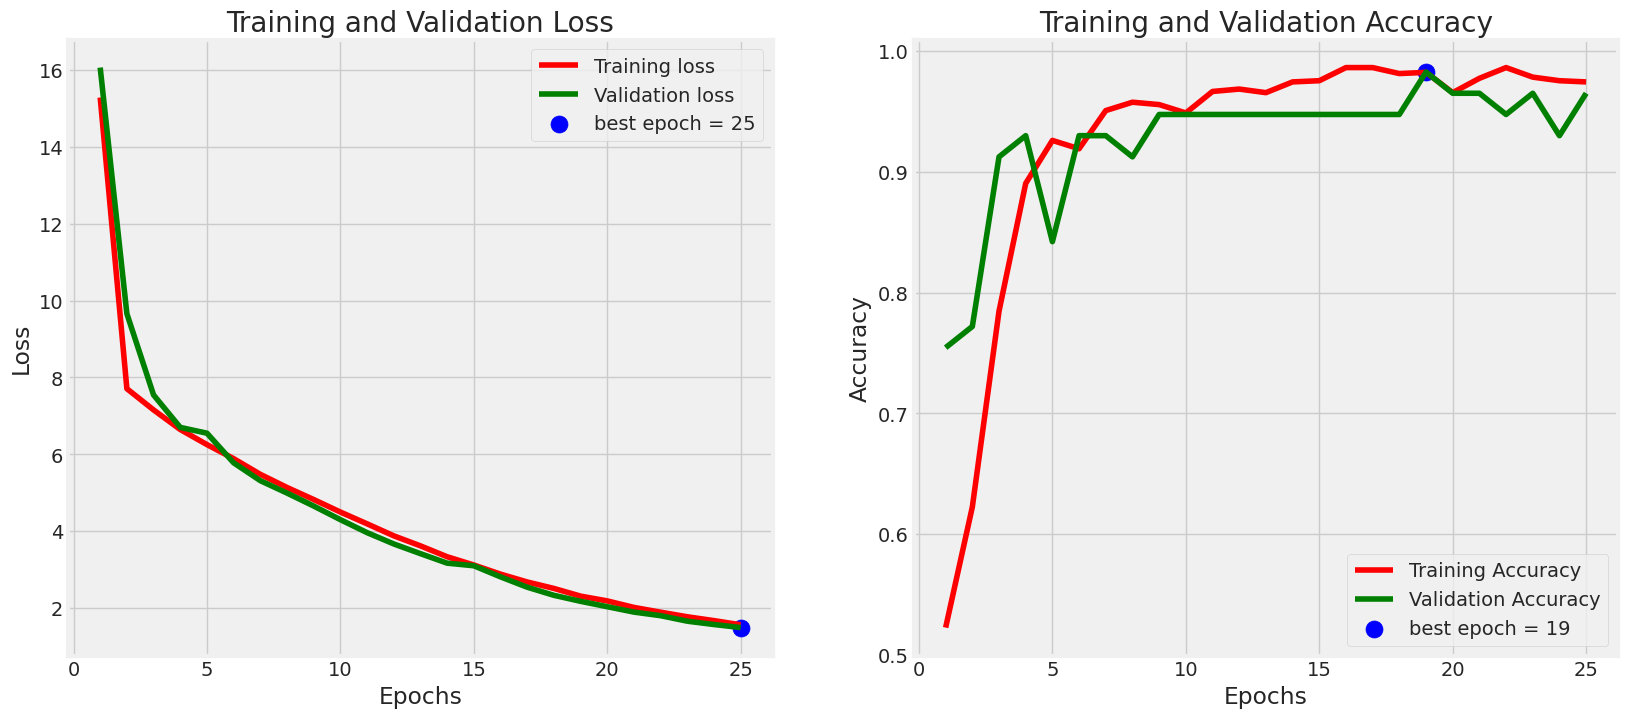

In [51]:
# Define needed variables

tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label = 'Training loss')
plt.plot(Epochs, val_loss, 'g', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [52]:
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.9684 - auc: 0.9988 - loss: 1.5063 - precision: 0.9942 - recall: 0.9544
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9526 - auc: 0.9969 - loss: 1.5079 - precision: 0.9504 - recall: 0.9087
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.9557 - auc: 0.9905 - loss: 1.5262 - precision: 0.9609 - recall: 0.9185


In [53]:
print('Train Loss : ', train_score[0])
print('Train Accuracy : ', train_score[1])
print('=' * 20)
print( )
print('Valid Loss : ', valid_score[0])
print('Valid Accuracy : ', valid_score[1])
print('=' * 20)
print( )
print('Test Loss : ', test_score[0])
print('Test Accuracy : ', test_score[1])

Train Loss :  1.5121864080429077
Train Accuracy :  0.970355749130249

Valid Loss :  1.4927605390548706
Valid Accuracy :  0.9649122953414917

Test Loss :  1.5660444498062134
Test Accuracy :  0.9464285969734192


4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step


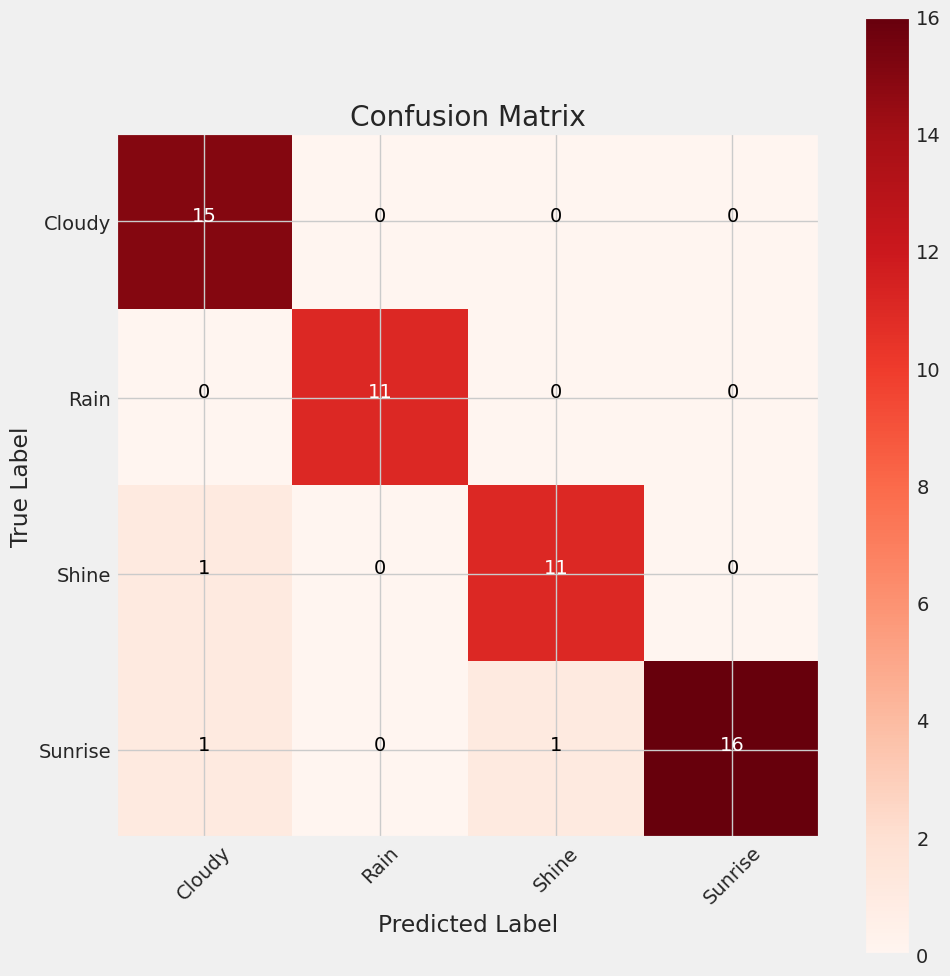

In [55]:
preds = model.predict(test_gen)
y_pred= np.argmax(preds,axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #(5,5)
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [57]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

print(classification_report(test_gen.classes, y_pred, target_names= classes))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
              precision    recall  f1-score   support

      Cloudy       0.88      1.00      0.94        15
        Rain       1.00      1.00      1.00        11
       Shine       0.92      0.92      0.92        12
     Sunrise       1.00      0.89      0.94        18

    accuracy                           0.95        56
   macro avg       0.95      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56

